# CommaAI Speed Challenge

In this notebook, we explore a solution to the speed prediction challenge by Comma AI.

## Imports

In [23]:
import copy
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms.functional as TF

from matplotlib import pyplot as plt
from time import time
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

## Helper Methods

In [24]:
def video_frame_generator(filename):
    """
    A generator function that returns a frame on each 'next()' call.

    :param str filename: The video filename.
    :return: A frame.
    """
    video = cv2.VideoCapture(filename)

    while video.isOpened():
        ret, frame = video.read()

        if ret:
            yield frame
        else:
            break

    video.release()

def preprocessed_frames_generator(filename):
    """
    A generator that preprocessed frames for the given video file.
    Images are converted to grayscale and resized to 224x224 as expected by pre-trained image models.

    :param str filename: The video filename.
    :return: Preprocessed frames, as a generator.
    :rtype: Iterator[numpy.ndarray]
    """
    for frame in video_frame_generator(filename):
        yield cv2.resize(cv2.cvtColor(np.copy(frame), cv2.COLOR_BGR2GRAY), (224, 224))

def normalize_and_scale(image, scale_range=(0, 255)):
    """
    Normalizes and scales an image to a given range.

    :param numpy.ndarray image: The image to normalize and scale.
    :param tuple scale_range: The range [min, max] for normalizing and scaling. Defaults to [0, 255].
    :return: The normalized image.
    :rtype: numpy.ndarray
    """
    image_out = np.zeros(image.shape)
    cv2.normalize(image, image_out, alpha=scale_range[0], beta=scale_range[1], norm_type=cv2.NORM_MINMAX)

    return image_out

## Motion History Images

Hyperparameters that need to be tuned are the **motion threshold** $\theta$ and the **time window threshold** $\tau$.

In [25]:
def motion_history_images_generator(images, tau=1, theta=0):
    """
    Generates motion history images from the given sequence of images.
    Based on "The Representation and Recognition of Action Using Temporal Templates" by Davis and Bobick (1997).

    :param list[numpy.ndarray] images: The sequence of images.
    :param int tau: The time window threshold. Defaults to 1.
    :param float theta: The motion threshold. Defaults to 0.
    :returns: Motion history images, as a generator.
    :rtype: Iterator[numpy.ndarray]
    """
    prev_image = None
    prev_mhi = None

    for image in images:
        # Compute motion binary image
        motion = ((np.abs(image.astype(np.float64) - prev_image.astype(np.float64)) > theta).astype(np.uint8)
                  if prev_image is not None else np.zeros_like(image, dtype=np.uint8))

        mhi = np.zeros_like(motion, dtype=np.float64)

        # Pixels with motion
        mhi[motion == 1] = tau
        # Decay pixels with no motion
        mhi[motion == 0] = prev_mhi[motion == 0] - 1 if prev_mhi is not None else 0
        # Make sure values don't go below 0
        mhi[mhi < 0] = 0

        prev_image = np.copy(image)
        prev_mhi = np.copy(mhi)
        
        yield np.copy(mhi)

### Example

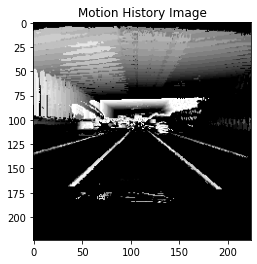

In [26]:
frames = []

for i, frame in enumerate(preprocessed_frames_generator('data/train.mp4')):
    frames.append(frame)
    if i == 20:
        break

# Use some example hyperparameters
mhis = list(motion_history_images_generator(frames, tau=20, theta=10))

plt.imshow(normalize_and_scale(mhis[-1]), cmap='gray', vmin=0, vmax=255)
plt.title('Motion History Image')
plt.show()

## Training Set

In [27]:
# TODO: Tune MHI hyperparameters
theta = 10
tau = 20  # 20 frames = 1 second of movement?

In [28]:
frames = preprocessed_frames_generator('data/train.mp4')
# The shape of our dataset will be (num_images, channels=3, w, h)
dataset_shape = (20400, 3, 224, 224)

# Create a memmap to stream our data to a file on disk
fp = np.memmap('data/train_X.npy', dtype='float64', mode='w+', shape=dataset_shape)
    
# Capacity at which to flush to disk
capacity = 0
max_capacity = 500

for i, mhi in enumerate(tqdm(motion_history_images_generator(frames, tau=tau, theta=theta), total=dataset_shape[0])):
    # MHI's are greyscale images but CNN models work with RGB images so we need to replicate the image across the 3 channels
    # See: https://stackoverflow.com/a/40119878
    # We also need to swap axes so that channels come first as expected by pre-trained image models
    # And, transform the MHI into the range [0, 1] as expected by pre-trained image models
    fp[i, :] = np.transpose(np.stack((mhi,) * 3, axis=-1), (2, 0, 1))
    fp[i, :] /= tau
    
    capacity += 1

    if capacity == max_capacity:
        # Flush to disk
        del fp
        # Create new memmap
        fp = np.memmap('data/train_X.npy', dtype='float64', mode='r+', shape=dataset_shape)
        capacity = 0

# Final flush to disk
del fp

# Load the correct speeds for the training set with shape (num_speeds, 1)
with open('data/train.txt', 'r') as f:
    np.save('data/train_y.npy', np.expand_dims(np.array([float(l) for l in f.readlines()]), axis=-1))

100%|██████████| 20400/20400 [02:49<00:00, 120.64it/s]


## Motion History Images Dataset

We will create a custom PyTorch dataset to stream the motion history images for training from disk to save on memory.

In [170]:
class MotionHistoryImagesDataset(Dataset):
    """Motion History Images dataset"""

    def __init__(self):
        # Create memmap to the mhi's file with copy-on-write so the data is writable in memory not on disk
        self._mhis = np.memmap('data/train_X.npy', dtype='float64', mode='c', shape=(20400, 3, 224, 224))
        # The speeds file is small enough we can load it completely in memory
        self._speeds = np.load('data/train_y.npy')

    def __len__(self):
        return len(self._mhis)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Perform some needed pre-processing:
        # 1. Convert to PyTorch tensor
        # 2. Convert to PyTorch's `float` explicitly since NumPy's `float64` is not allowed
        #    See: https://tinyurl.com/ybp4ax86
        # 3. Normalize the images as expected by pre-trained image models
        #    See: https://pytorch.org/hub/pytorch_vision_resnet/
        mhis = torch.from_numpy(self._mhis[idx, :]).float()
        mhis = TF.normalize(mhis, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        speeds = torch.from_numpy(self._speeds[idx, :]).float()
        
        return mhis, speeds

## Dataset Preparation

We will split the training dataset into training and dev sets using a 95% to 5% split; respectively. And create `DataLoader` objects for each with batches of size 64.

In [204]:
# Set the seed for reproducibility
torch.manual_seed(0)

train_set, dev_set = torch.utils.data.random_split(MotionHistoryImagesDataset(), [19380, 1020])
loaders = {name: DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4)
           for name, dataset in [('train', train_set), ('dev', dev_set)]}
sizes = {'train': 19380, 'dev': 1020}

### Example

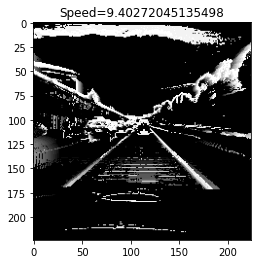

In [205]:
for frames, speeds in loaders['train']:
    frame = frames.numpy()[0, 0, :]
    speed = np.squeeze(speeds.numpy()[0, :])

    plt.imshow(normalize_and_scale(frame.astype(np.float64)), cmap='gray', vmin=0, vmax=255)
    plt.title(f'Speed={speed}')
    plt.show()
    
    break

## Model Definition

In [209]:
# Choose device based on CPU vs GPU availability
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Use transfer learning with a pre-trained ResNet-18 model
model = torchvision.models.resnet18(pretrained=True)

# Freeze all weights since we won't be tuning the full model
for param in model.parameters():
    param.requires_grad = False

# Replace the last layer with a linear (regression) output
features = model.fc.in_features
model.fc = nn.Linear(features, 1)

model = model.to(device)

# We'll use MSE as the loss
loss_fn = nn.MSELoss()

# Use Stochastic Gradient Descent, and optimize only the parameters of the last layer
# Add momentum to speed up training
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

# Also decay learning rate by a factor of 0.1 every 7 epochs
learning_rate_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

## Model Training

In [210]:
# TODO: Tune number of epochs
num_epochs = 5

In [211]:
# Training routine modified from: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#training-the-model

# Set the seed for reproducibility
torch.manual_seed(0)

start = time()

best_model = copy.deepcopy(model.state_dict())
best_loss = np.inf

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'dev']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0

        # Iterate over data
        for frames, speeds in loaders[phase]:
            frames = frames.to(device)
            speeds = speeds.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            # Track history if only in training
            with torch.set_grad_enabled(phase == 'train'):
                predictions = model(frames)
                loss = loss_fn(predictions, speeds)
                
                # Backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # Statistics
            running_loss += loss.item() * frames.size(0)

        # Decay learning rate when appropriate
        if phase == 'train':
            learning_rate_scheduler.step()

        # Global statistics
        epoch_loss = running_loss / sizes[phase]

        print('{} Loss: {:.4f}'.format(phase, epoch_loss))

        # Deep copy the best model based on the dev set
        if phase == 'dev' and epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model = copy.deepcopy(model.state_dict())

    print()

time_elapsed = time() - start
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best dev loss: {:4f}'.format(best_loss))

# Save best model weights
torch.save(best_model, 'model/speednet.pt')

Epoch 0/4
----------
train Loss: 24.5049
dev Loss: 11.4890

Epoch 1/4
----------
train Loss: 24.1003
dev Loss: 11.1631

Epoch 2/4
----------
train Loss: 19.4163
dev Loss: 14.6316

Epoch 3/4
----------
train Loss: 17.8611
dev Loss: 13.8609

Epoch 4/4
----------
train Loss: 17.2748
dev Loss: 11.8186

Training complete in 3m 29s
Best dev loss: 11.163141
